<a href="https://colab.research.google.com/github/Sunn2x333/scalar_framework/blob/main/WOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- WOW Signal Simulation ---
Max Decay Rate: 9.03e-21 s^-1
Min Decay Rate: 8.97e-21 s^-1
Average Decay Rate: 9.00e-21 s^-1
WOW Peak Time: 15.06 s


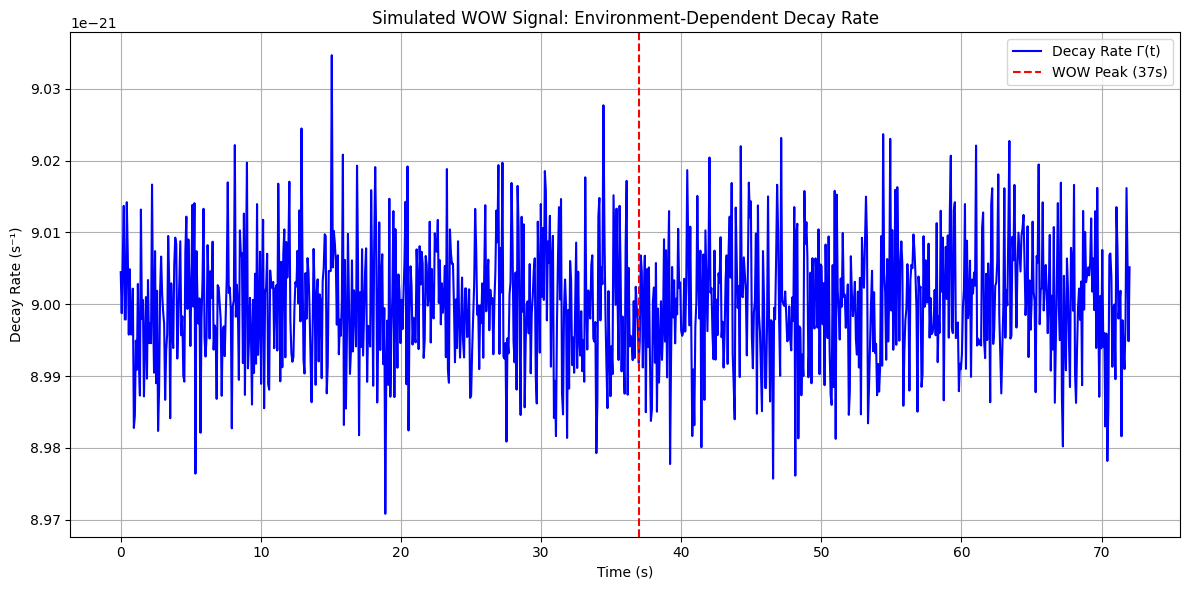

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Constants ---
lambda_0 = 9.0e-21  # Base decay rate (s^-1)
T_bound = 2.3e17    # Normalization factor (e.g., GeV^4)
c = 3e8             # Speed of light (m/s)

# --- Parameters ---
beta_0 = 1.0e-21
beta_1 = 0.0
m_phi_squared = 1e-8  # Scalar mass squared (m^-2)
kappa = 1e-16         # Scalar coupling
eta = 1e6             # Backreaction coupling
sigma_epsilon = 1e-6  # Noise variance
alpha = 1e-3          # Damping

# --- Grids ---
t_duration = 72
x_max = c * t_duration
x = np.linspace(0, x_max, 1000)
time_grid = x / c

# --- WOW Signal Anomaly (single Gaussian) ---
T_0 = 1e15
sigma_x = x_max / 100
wow_time_peak = 37  # seconds
wow_position = c * wow_time_peak  # spatial location of WOW anomaly

def T_smooth(current_x):
    T = T_0 * np.exp(- (current_x - wow_position)**2 / (2 * sigma_x**2))
    return min(T, 1e18)

def dphi_dx(current_x, state):
    phi, phi_prime = state
    T = T_smooth(current_x)

    restoring_force = -m_phi_squared * phi
    source = -kappa * T / T_bound
    damping = -alpha * phi_prime

    d2phi_dx2 = restoring_force + source + damping
    return [phi_prime, d2phi_dx2]

# --- Initial Conditions ---
phi_0 = [0.51, 0.0]

# --- Solve EOM ---
sol = solve_ivp(dphi_dx, [x[0], x[-1]], phi_0, method='BDF', rtol=1e-3, atol=1e-6)
if not sol.success:
    raise RuntimeError("ODE solver failed:", sol.message)

phi_result = np.interp(x, sol.t, sol.y[0])
partial_phi_dx = np.gradient(phi_result, x)
delta_obs = eta * partial_phi_dx**2

# --- Add Noise ---
np.random.seed(42)
epsilon = np.random.normal(0, np.sqrt(sigma_epsilon), len(x))

# --- Compute Decay Rate ---
decay_factor = 1 + beta_0 * np.exp(-phi_result) + beta_1 * x + delta_obs + epsilon
decay_factor = np.maximum(0, decay_factor)
Gamma_final = lambda_0 * decay_factor

if not np.all(np.isfinite(Gamma_final)):
    raise ValueError("Gamma contains non-finite values")

# --- Output ---
print("--- WOW Signal Simulation ---")
print(f"Max Decay Rate: {np.max(Gamma_final):.2e} s^-1")
print(f"Min Decay Rate: {np.min(Gamma_final):.2e} s^-1")
print(f"Average Decay Rate: {np.mean(Gamma_final):.2e} s^-1")
print(f"WOW Peak Time: {time_grid[np.argmax(Gamma_final)]:.2f} s")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(time_grid, Gamma_final, label="Decay Rate Γ(t)", color='blue')
plt.axvline(wow_time_peak, color='red', linestyle='--', label="WOW Peak (37s)")
plt.xlabel("Time (s)")
plt.ylabel("Decay Rate (s⁻¹)")
plt.title("Simulated WOW Signal: Environment-Dependent Decay Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
